# Set Up

Version requirements for the packages.

In [ ]:
# tensorflow==2.10.0
# Cython==0.29.32
# numpy==1.21.6
# matplotlib==3.2.2
# seaborn==0.11.2
# scipy==1.7.3
# scikit-learn==1.0.2
# scikit-image==0.18.3
# pandas==1.3.5
# pyyaml==6.0
# imutils==0.5.4
# opencv-python==4.6.0.66
# tqdm==4.64.1
# psutil==5.4.8
# h5py==3.1.0

Let's install all the packages that we are going to use.

In [ ]:
# If we are running on google colab we need to install tensorflow 2.10.0 
!pip install tensorflow==2.10.0

# tsaug for data augmentation of time series
!pip install tsaug

# doppelGANger for time series generation
!pip install gretel-synthetics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import all the libraries.

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from keras.utils.vis_utils import plot_model
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType, Normalization
from scipy import stats
from collections import Counter
from sklearn.utils import class_weight 
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
import logging
import tsaug
from keras.utils.data_utils import get_file
from imblearn.under_sampling import EditedNearestNeighbours


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [ ]:
# Check which GPU is running
!nvidia-smi

Thu Dec 22 11:58:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Data Import and Preprocessing

We spent the majority of our time in the analysis and preprocessing phase.

## Data import

 Download the dataset and put it in the Temp directory.

In [ ]:
if os.path.isdir('Temp')==False:
  os. mkdir("Temp")
dataset_path = get_file(
            'dataset.zip',
            'https://drive.google.com/uc?export=download&id=1XEX12SzlpnTnzNkwEMt66Xo3XLF-vmK6&confirm=t',
            cache_dir="Temp")

# extract the zip file in the content directory 
!unzip Temp/datasets/dataset.zip

2294245/2294245 [==============================] - 0s 0us/step
Archive:  Temp/datasets/dataset.zip
  inflating: y_train.npy             
  inflating: x_train.npy             


Load the dataset.

In [ ]:
X = np.load("x_train.npy")
y = np.load("y_train.npy")

In [ ]:
X.shape, y.shape

((2429, 36, 6), (2429,))

 We associate to each label an integer number.

In [ ]:
label_mapping={
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine"

}

Dataset split in train, validation and test sets.

In [ ]:
# the test set is 1/10 of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/10, random_state=seed)
# the validation set is 1/10 of the dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=seed) #1/9 * 9/10 = 1/10

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
y_val = tfk.utils.to_categorical(y_val)
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((1943, 36, 6), (243, 36, 6), (1943, 12), (243, 12))

## Visualization

Plot the distribution of the data in the training set

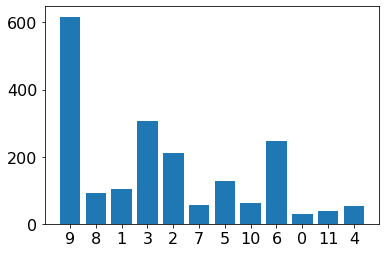

Counter({9: 617, 3: 306, 6: 247, 2: 210, 5: 129, 1: 104, 8: 92, 10: 62, 7: 56, 4: 53, 11: 37, 0: 30})


In [ ]:
from collections import Counter
counter = Counter(np.argmax(y_train,-1))
plt.bar(range(len(counter)), list(counter.values()), align='center')
plt.xticks(range(len(counter)), list(counter.keys()))
plt.show()
print(counter)

As we can see there is a problem of **class imbalance**!

We define a function for visualizing our time series.

In [ ]:
def inspect_series(x,y):
  data = pd. DataFrame(x, columns=['Column1', 'Column2','Column3', 'Column4','Column5', 'Column6'])
  axis = data.plot(subplots=True, figsize=(17, 9), title=label_mapping.get(np.argmax(y)))
  for ax in axis:
      ax.legend(loc='lower right')

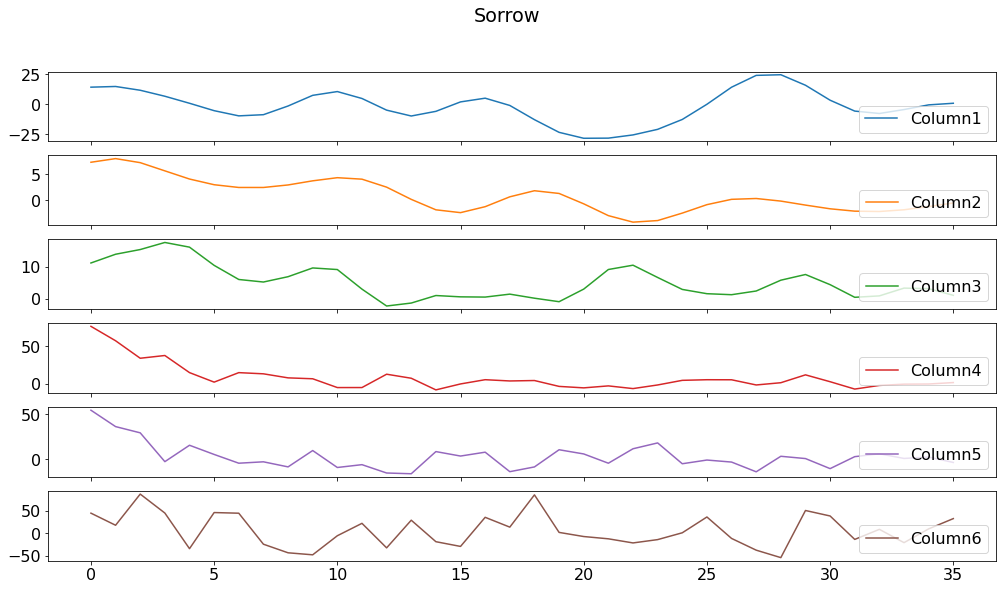

In [ ]:
inspect_series(X_train[0],y_train[0])

We visualize the values of each feature in order to understand our data.

In [ ]:
#define the shapes
X_train_shape = X_train.shape
X_test_shape = X_test.shape
x_val_shape = X_val.shape

We have to reshape our time series removing the segmentation window to perform analysis.

In [ ]:
X_train_reshaped = X_train.reshape((X_train_shape[0] * X_train_shape[1],X_train_shape[2]))
X_test_reshaped = X_test.reshape((X_test_shape[0] * X_test_shape[1],X_test_shape[2]))
X_valid_reshaped = X_val.reshape((X_test_shape[0] * X_test_shape[1],X_test_shape[2]))

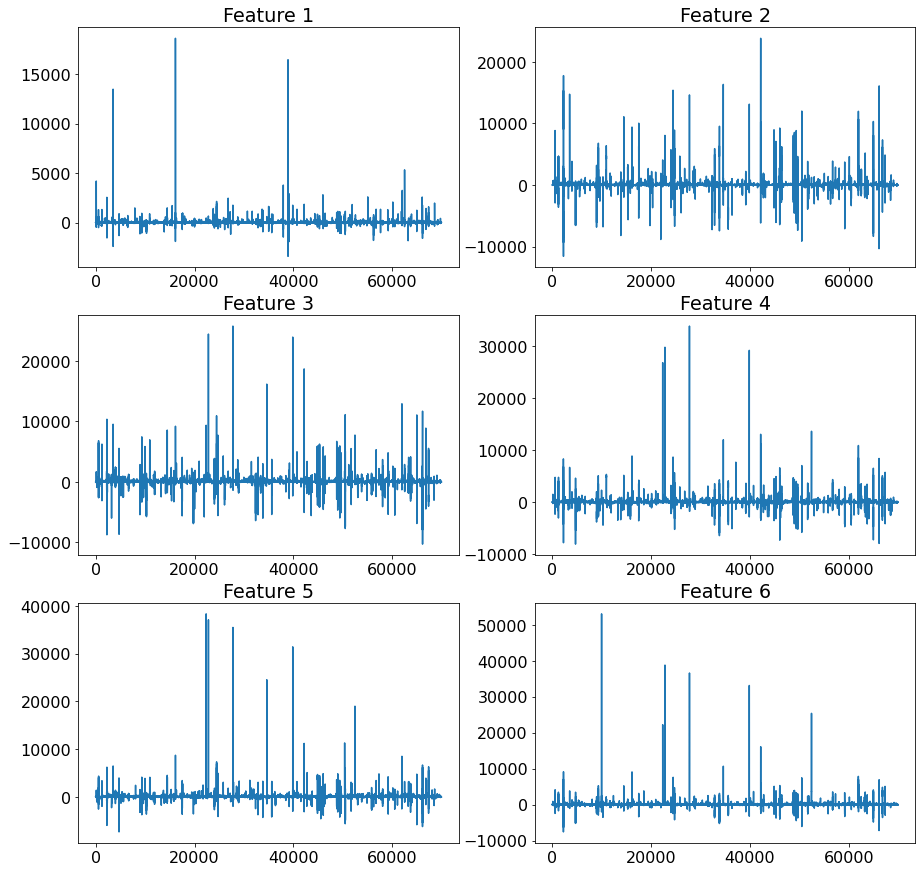

In [ ]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
axis = axis.flatten()
for i in range(6):
  axis[i].plot(X_train_reshaped[:,i])
  axis[i].set_title("Feature {}".format(i+1))

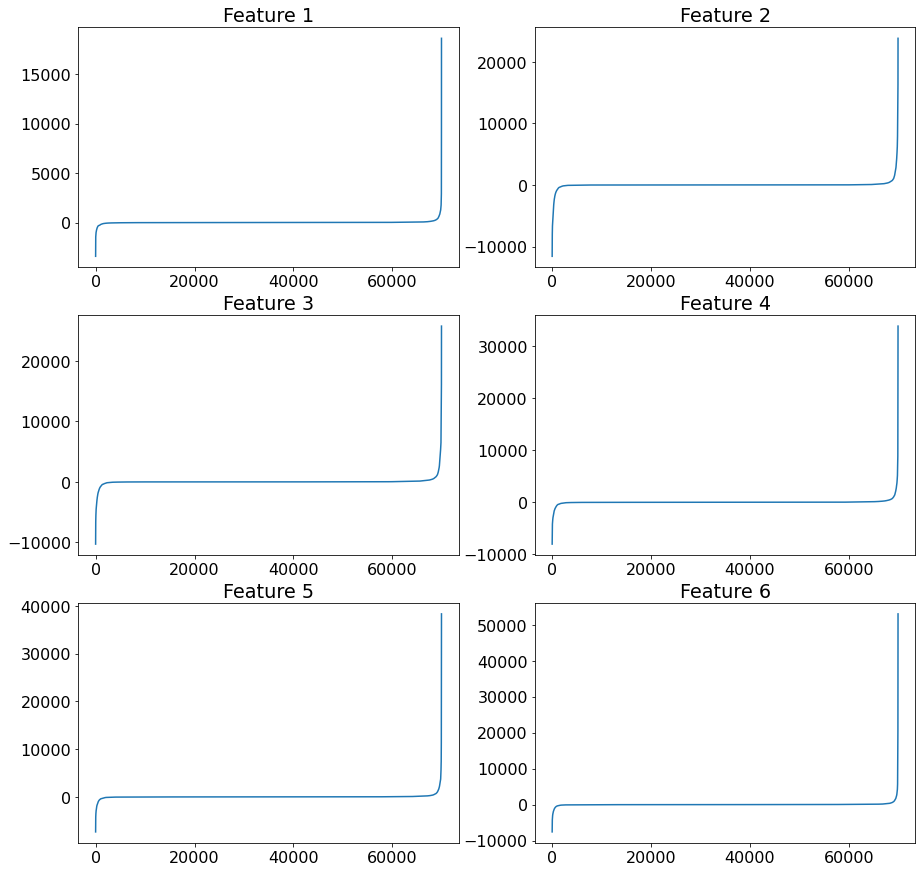

In [ ]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
axis = axis.flatten()
for i in range(6):
  axis[i].plot(np.sort(X_train_reshaped[:,i]))
  axis[i].set_title("Feature {}".format(i+1))

As we can see there is a problem of **outliers** that we have to handle!

## Outliers Detection

### Median Absolute Deviation (MAD)

The median absolute deviation (MAD) is an alternative to the standard deviation for finding outliers in one-dimensional data. MAD is defined as the median of the absolute deviations from the series median. 

In [ ]:
def PrintAnomalyLimits(X):
    mad = stats.median_abs_deviation(X, scale='normal')
    for c in range(X.shape[1]):
        mean = X[:,c].mean()
        std = X[:,c].std()
        median = np.median(X[:,c])


        lower = mean - 3*std
        upper = mean + 3*std
        mad_lower = median - 3*mad[c]
        mad_upper = median + 3*mad[c]
        
        print("Variable X%d (%.3f,%.3f)"%(c,mean,std))
        print("\tStandard Deviation Limits (%.3f,%.3f)"%(lower,upper))
        print("\tMAD Limits (%.3f,%.3f)"%(mad_lower,mad_upper))

In [ ]:
PrintAnomalyLimits(X_train_reshaped)

Variable X0 (9.352,216.962)
	Standard Deviation Limits (-641.533,660.237)
	MAD Limits (-19.619,20.163)
Variable X1 (22.229,744.429)
	Standard Deviation Limits (-2211.058,2255.517)
	MAD Limits (-11.395,12.257)
Variable X2 (28.716,666.986)
	Standard Deviation Limits (-1972.243,2029.674)
	MAD Limits (-15.273,16.606)
Variable X3 (36.273,670.664)
	Standard Deviation Limits (-1975.718,2048.265)
	MAD Limits (-22.076,24.023)
Variable X4 (38.599,674.462)
	Standard Deviation Limits (-1984.786,2061.983)
	MAD Limits (-35.769,38.404)
Variable X5 (36.326,748.218)
	Standard Deviation Limits (-2208.329,2280.981)
	MAD Limits (-60.189,64.461)


Instead of using the standard deviation values, we can use MAD values that are more robust than standard deviation with respect to the range of the outliers. Typically the lower and upper limit to define anomalies are taken by subtracting/adding 2xMAD multiplied by an adjustment coefficient to the median.

In [ ]:
def CleanMADOutliers(X, tolerance=3):
    # we compute the mad from the stats function
    mad = stats.median_abs_deviation(X, scale='normal')
    X = X.copy()
    # the coefficient is usually twice the mad multiplied by a tolerance factor
    for c in range(X.shape[1]):
        # we compute the statistical measures
        mean = np.mean(X[:,c])
        std = np.std(X[:,c])
        median = np.median(X[:,c])
        lower = median - tolerance*mad[c]
        upper = median + tolerance*mad[c]
        # we define the outliers 
        outliers = ((X[:,c]>upper) | (X[:,c]<lower))

        if (outliers.sum()>0):
            print("Variable X%d (%.3f,%.3f) has %d/%d outliers"%(c,mean,std,outliers.sum(),X.shape[0]))
            # we set the default value for the outliers as the median 
            X[outliers==True,c] = median
            print("\t===============================")

        else:
            print("Variable X%d has no outliers")
    return X

In this way we clean our dataset from the outliers.

In [ ]:
X_train_cleaned = CleanMADOutliers(X_train_reshaped, tolerance = 3)

Variable X0 (9.352,216.962) has 13866/69948 outliers
Variable X1 (22.229,744.429) has 18864/69948 outliers
Variable X2 (28.716,666.986) has 19035/69948 outliers
Variable X3 (36.273,670.664) has 17417/69948 outliers
Variable X4 (38.599,674.462) has 13921/69948 outliers
Variable X5 (36.326,748.218) has 11120/69948 outliers


We plot again the features, as we can see we have more smooth curves.

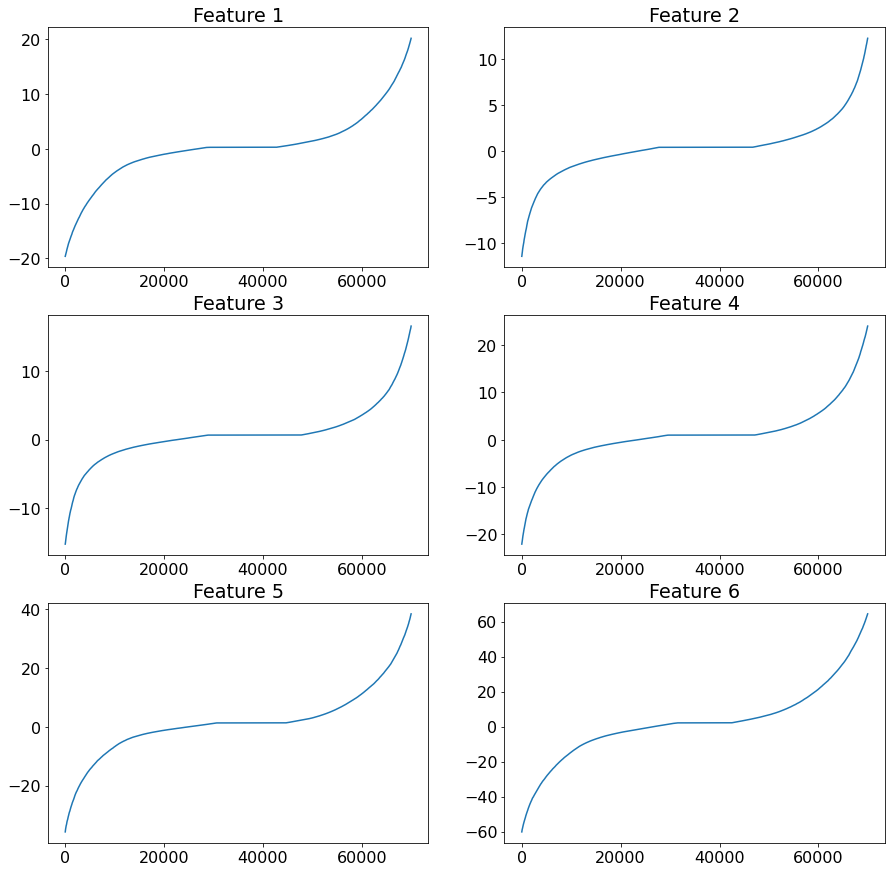

In [ ]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
axis = axis.flatten()
for i in range(6):
  axis[i].plot(np.sort(X_train_cleaned[:,i]))
  axis[i].set_title("Feature {}".format(i+1))

This method yielded no results but we reported it anyway for its analytical importance. 

## Normalization

Another method for handling outliers in the dataset is using a suited normalization.

We reshape again our dataset.

In [ ]:
X_train_shape = X_train.shape
X_test_shape = X_test.shape
X_val_shape = X_val.shape

In [ ]:
X_train_reshaped = X_train.reshape((X_train_shape[0] * X_train_shape[1],X_train_shape[2]))
X_test_reshaped = X_test.reshape((X_test_shape[0] * X_test_shape[1],X_test_shape[2]))
X_val_reshaped = X_val.reshape((X_val_shape[0] * X_val_shape[1],X_val_shape[2]))

We started with the MinMax and the Standard scaler, but they are the most sensitive to outliers, we proceeded trying two more robust scaler


*   RobustScaler
*   PowerTransform



### RobustScaler

This Scaler removes the median and scales the data according to the quantile range.

In [ ]:
# Apply RobustScaler to all the features
scaler = RobustScaler(quantile_range=(25,75)) # we use the classical quantile range
# we fit the scaler on our train set and we apply it on all our sets
scaler = scaler.fit(X_train_reshaped)
X_train_reshaped_norm = scaler.transform(X_train_reshaped)
X_test_reshaped_norm = scaler.transform(X_test_reshaped)
X_val_reshaped_norm = scaler.transform(X_val_reshaped)

# we then reshape
X_train = X_train_reshaped_norm.reshape(X_train_shape)
X_test = X_test_reshaped_norm.reshape(X_test_shape)
X_val = X_val_reshaped_norm.reshape(X_val_shape)


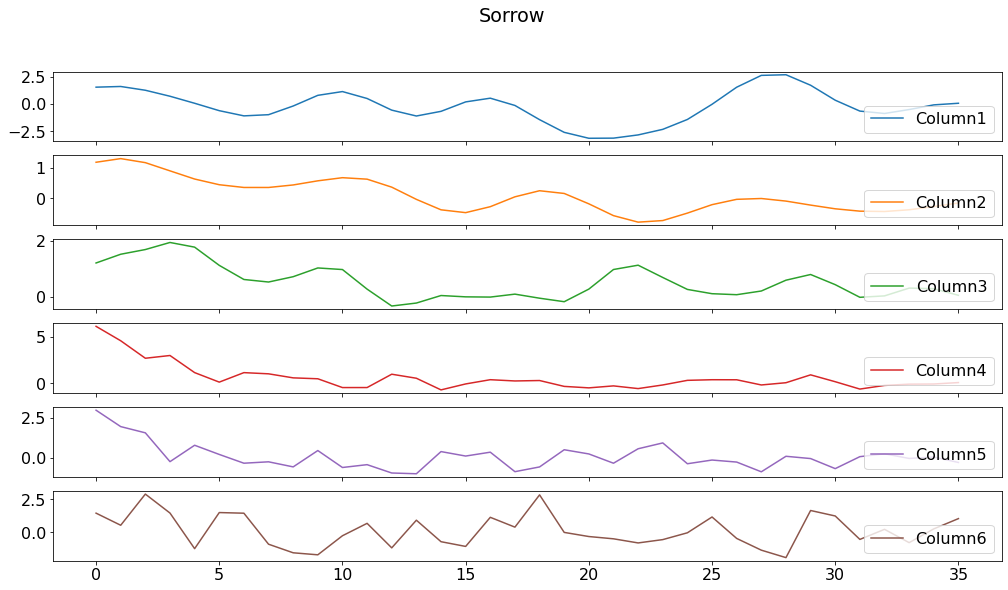

In [ ]:
inspect_series(X_train[0],y_train[0])

### PowerTransform

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. 

In [ ]:
#Apply PowerTransformer to all the features
scaler = PowerTransformer()
# we fit the scaler on our train set and we apply it on all our sets
scaler = scaler.fit(X_train_reshaped)
X_train_reshaped_norm = scaler.transform(X_train_reshaped)
X_test_reshaped_norm = scaler.transform(X_test_reshaped)
X_val_reshaped_norm = scaler.transform(X_val_reshaped)

# we then reshape
X_train = X_train_reshaped_norm.reshape(X_train_shape)
X_test = X_test_reshaped_norm.reshape(X_test_shape)
X_val = X_val_reshaped_norm.reshape(X_val_shape)

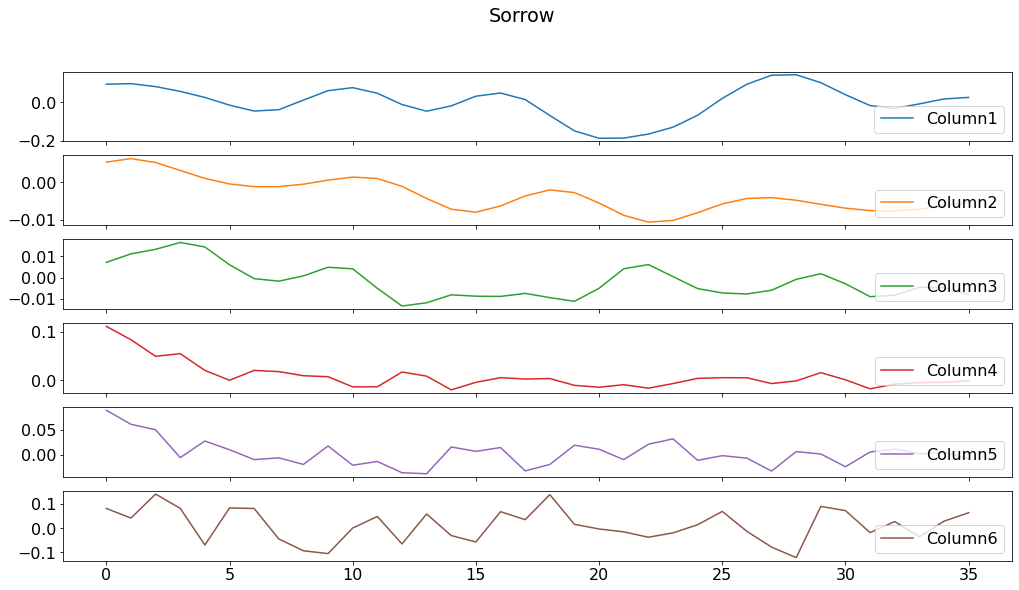

In [ ]:
inspect_series(X_train[0],y_train[0])

Both led us to good results but in the end the PowerTransformer came out on top.

## Class Imbalance

In order to handle the class imbalance problem we tried different techniques.

### Class Weights

We give a weights to each feature based on the number of occurences.

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                  classes=np.unique(np.argmax(y_train,axis=-1)),
                                                  y=np.argmax(y_train,axis=-1))
class_weights = {i : class_weights[i] for i in range(12)}
class_weights

{0: 5.397222222222222,
 1: 1.5568910256410255,
 2: 0.7710317460317461,
 3: 0.5291394335511983,
 4: 3.0550314465408803,
 5: 1.2551679586563307,
 6: 0.6555330634278003,
 7: 2.8913690476190474,
 8: 1.7599637681159421,
 9: 0.2624257158292815,
 10: 2.611559139784946,
 11: 4.376126126126126}

This method resulted in worse performances, so we didn't use it.

### Edited Nearest Neighbours Downsampling

The Edited Nearest Neighbors Rule classifies each sample with a k=3 Nearest Neighbors; if a sample belonging to the majority class is misclassified by its Three-Nearest-Neighbours, it is deleted from the dataset.


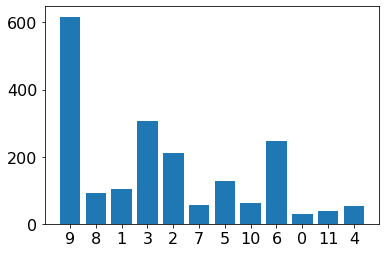

Counter({9: 617, 3: 306, 6: 247, 2: 210, 5: 129, 1: 104, 8: 92, 10: 62, 7: 56, 4: 53, 11: 37, 0: 30})


In [ ]:
# we first plot the number of samples for each class before applying downsampling
counter = Counter(np.argmax(y_train,-1))
plt.bar(range(len(counter)), list(counter.values()), align='center')
plt.xticks(range(len(counter)), list(counter.keys()))
plt.show()
print(counter)

In [ ]:
# we reshape the input for applying the method
X_train_shape = X_train.shape
X_train_reshaped = X_train.reshape((X_train_shape[0], X_train_shape[1] * X_train_shape[2]))

In [ ]:
# Undersample the imbalanced dataset with EditedNearestNeighbours applied to them majority class

# define the undersampling method
undersample = EditedNearestNeighbours(sampling_strategy="majority", n_neighbors=3, kind_sel='mode')
# transform the dataset
X_train_res, y_train_undersampled = undersample.fit_resample(X_train_reshaped, y_train)

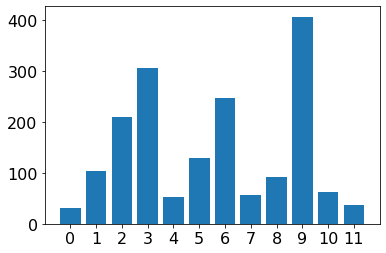

Counter({9: 406, 3: 306, 6: 247, 2: 210, 5: 129, 1: 104, 8: 92, 10: 62, 7: 56, 4: 53, 11: 37, 0: 30})


In [ ]:
# we reshape the samples in the original form and we plot the new distribution
X_train_undersampled = np.reshape(X_train_res, (X_train_res.shape[0], int(X_train_res.shape[1]/X_train_shape[2]), X_train_shape[2]))
counter = Counter(np.argmax(y_train_undersampled,-1))
plt.bar(range(len(counter)), list(counter.values()), align='center')
plt.xticks(range(len(counter)), list(counter.keys()))
plt.show()
print(counter)

This technique was effective in reducing the size of the majority class but did not produce interesting results.

### Random Duplication

Our classes were very unbalanced, so this approach was not very effective.

### Synthetic Minority Oversampling Technique (SMOTE)

 SMOTE first selects a minority class instance “a”' at random and finds its k nearest minority class neighbors. Then one of the k nearest neighbors “b” is chosen and a line segment connecting “a” and “b”  is created in the feature space. The synthetic sample is generated on that line

In [ ]:
# here we perform some reshaping for applying the method
orig_shape = X_train.shape

new_train = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))

new_y_train = []
for i in range(len(y_train)):
    new_y_train.extend([y_train[i]] * X_train.shape[1])

new_y_train = np.argmax(np.array(new_y_train),axis=-1)

In [ ]:
# we print some information about the samples before and after applying SMOTE
for label in label_mapping:
  print("Before OverSampling, counts of label '{}': {}".format(label, sum(new_y_train == label)))

sm = SMOTE(random_state = seed)
X_train_res, y_train_res = sm.fit_resample(new_train, new_y_train.ravel())

print('\nAfter OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

for label in label_mapping:  
  print("After OverSampling, counts of label '{}': {}".format(label, sum(y_train_res == 1)))
  
reshaped_train = np.reshape(X_train_res, (int(X_train_res.shape[0]/X_train.shape[1]), X_train.shape[1], X_train.shape[2] ))
print(reshaped_train.shape)

y_train_new = []
for i in range(int(X_train_res.shape[0]/X_train.shape[1])):
    value_list = list(y_train_res.reshape(int(X_train_res.shape[0]/X_train.shape[1]), X_train.shape[1])[i])
    y_train_new.extend(list(set(value_list)))
    ## Check: if there is any different value in a list 
    if len(set(value_list)) != 1:
        print('\n\n********* STOP: THERE IS SOMETHING WRONG IN TRAIN ******\n\n')
y_train_new = np.array(y_train_new)

Before OverSampling, counts of label '0': 1080
Before OverSampling, counts of label '1': 3744
Before OverSampling, counts of label '2': 7560
Before OverSampling, counts of label '3': 11016
Before OverSampling, counts of label '4': 1908
Before OverSampling, counts of label '5': 4644
Before OverSampling, counts of label '6': 8892
Before OverSampling, counts of label '7': 2016
Before OverSampling, counts of label '8': 3312
Before OverSampling, counts of label '9': 22212
Before OverSampling, counts of label '10': 2232
Before OverSampling, counts of label '11': 1332

After OverSampling, the shape of train_X: (266544, 6)
After OverSampling, the shape of train_y: (266544,) 

After OverSampling, counts of label '0': 22212
After OverSampling, counts of label '1': 22212
After OverSampling, counts of label '2': 22212
After OverSampling, counts of label '3': 22212
After OverSampling, counts of label '4': 22212
After OverSampling, counts of label '5': 22212
After OverSampling, counts of label '6': 

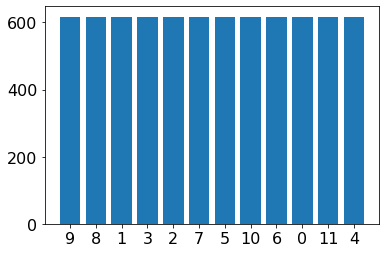

Counter({9: 617, 8: 617, 1: 617, 3: 617, 2: 617, 7: 617, 5: 617, 10: 617, 6: 617, 0: 617, 11: 617, 4: 617})


In [ ]:
counter = Counter(y_train_new)
plt.bar(range(len(counter)), list(counter.values()), align='center')
plt.xticks(range(len(counter)), list(counter.keys()))
plt.show()
print(counter)

We obtain in this way a perfectly balanced dataset.

Unfortunately not even this technique has allowed us to obtain improvements so we did not use it but we report it because it is an interesting and potentially useful method in these situations.

## Data Augmentation

### GAN with DoppelGANger 

We tried a generative approach for class balancing

In [ ]:
# this function takes as input the dataset (X,y)
# a class cl 
# the number n of samples to be generated
def GenerateTimeSeries(X,y, cl, n):
  # extract the feature of the given class
  features = X[np.argmax(y,axis=-1)==cl]
  # define the model
  model = DGAN(DGANConfig(
      max_sequence_len=36,
      sample_len=4,
      batch_size=1000,
      epochs=10,  # For real data sets, 100-1000 epochs is typical
  ))

  # train the model
  model.train_numpy(
      features=features,
      feature_types = [OutputType.CONTINUOUS] * 6
  )

  # Generate synthetic data
  _, synthetic_features = model.generate_numpy(n)
  return synthetic_features

In [ ]:
# this function takes as input an inbalanced dataset, and gives as output a balanced one with generated time series
def BalanceWithGAN(X, y):
  X_gan = X.copy()
  y_gan = y.copy()
  # get the number of samples of majority class
  maxval = int(y_gan.sum(axis=0).max())
  # for each class generate samples until we have the maxval number
  for i in range(12):
      print("class: {}".format(i))
      val = X[np.argmax(y,axis=-1) == i].shape[0]
      if maxval - val > 0:
        # generate the time series
        X_class = GenerateTimeSeries(X,y, i, maxval - val)
        y_class = tfk.utils.to_categorical([i] * X_class.shape[0], 12)
        # append the generated samples to the dataset
        X_gan = np.concatenate((X_gan, X_class))
        y_gan = np.concatenate((y_gan, y_class))
  return X_gan, y_gan

In [ ]:
X_train_gan,y_train_gan = BalanceWithGAN(X_train, y_train)

class: 0
class: 1
class: 2
class: 3
class: 4
class: 5
class: 6
class: 7
class: 8
class: 9
class: 10
class: 11


In [ ]:
#shuffle the dataset
train = list(zip(X_train_gan, y_train_gan))
random.shuffle(train)
X_train_gan, y_train_gan = zip(*train)
X_train_gan = np.array(X_train_gan)
y_train_gan = np.array(y_train_gan)

This method was very promising but it didn't come in handy so we didn't use it in the end.

### Classic Augmentation

We tried different types of augmentations for expanding our dataset and regularize our model.

In [ ]:
# these are the useful augmentations we applied
augs = []

#Time warp
X_aug_1 = tsaug.TimeWarp(n_speed_change=3, max_speed_ratio=3).augment(X_train)
#Drift
X_aug_2 = tsaug.Drift(max_drift=1.5, n_drift_points=5).augment(X_train)
#Crop + Resize
X_aug_3 = tsaug.Reverse().augment(X_train)
#Add noise -> segment
X_aug_4 = tsaug.AddNoise(scale=0.1).augment(X_train)
#Convolve -> smoothin
X_aug_5 = tsaug.Convolve(window="flattop", size=11).augment(X_train)

augs.extend([X_aug_1,X_aug_2,X_aug_3,X_aug_4,X_aug_5])

We applied them in a random manner.

In [ ]:
# this function takes as input the dataset X and return an augmented version of it
def random_augmenter(X):
    X_shape = X.shape
    # we randomly decide the number of augmentations (minimum 1, maximum 5)
    n = np.random.randint(1,6)
    # we randomly choose them
    chosen = np.random.choice([
        tsaug.TimeWarp(n_speed_change=3, max_speed_ratio=3),
        tsaug.Reverse(),
        tsaug.Drift(max_drift=1.5, n_drift_points=5),
        tsaug.AddNoise(scale=0.1),
        tsaug.Convolve(window="flattop", size=11),
    ],n)
    # we apply them iteratively to X
    for aug in chosen:
        X = aug.augment(X)
    return X

We then apply this random augmenter 10 times to our dataset, thus obtaining a dataset 10 times larger.

In [ ]:
# we include in the augmented dataset the original one
X_train_aug = X_train.copy()
y_train_aug = y_train.copy()
for i in range(10):
  aug = random_augmenter(X_train)
  X_train_aug = np.concatenate((X_train_aug, aug))
  y_train_aug = np.concatenate((y_train_aug,y_train))

# shuffle the dataset
train = list(zip(X_train_aug, y_train_aug))
random.shuffle(train)
X_train_aug, y_train_aug = zip(*train)
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

X_train_aug.shape, y_train_aug.shape

((21373, 36, 6), (21373, 12))

This is the method we ended up using.

# Training

We report here all the models suitable for the time series classification for completeness.


We ended up using a 1D Convolutional model because it was the most accurate.

We define the training parameters.

In [ ]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 32
epochs = 200

## LSTM

The first model we tried was a LSTM.

In [ ]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)
    lstm = tfkl.LSTM(128)(dropout)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-2), metrics='accuracy')

    # Return the model
    return model

In [ ]:
modelLSTM = build_LSTM_classifier(input_shape, classes)
modelLSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 128)           69120     
                                                                 
 dropout (Dropout)           (None, 36, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 12)                1548  

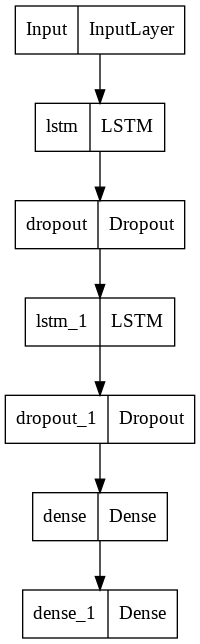

In [ ]:
plot_model(modelLSTM)

## Bidirectional LSTM

We then proceed to with a bidirectional LSTM.

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(dropout)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
modelBILSTM = build_BiLSTM_classifier(input_shape, classes)
modelBILSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 36, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896 

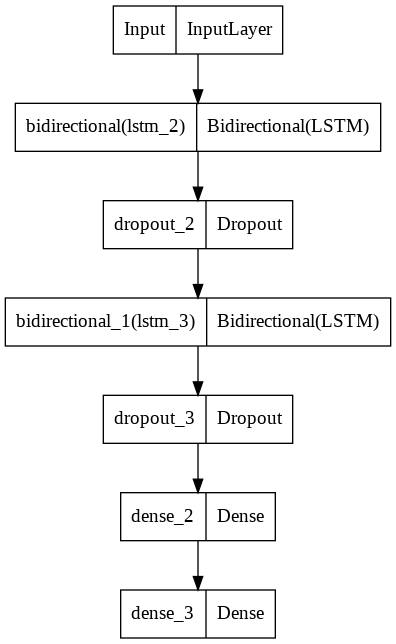

In [ ]:
plot_model(modelBILSTM)

## ResNet

We also tried a Residual Network approach with 3 residual block of different kernel sizes and number of filters.

In [ ]:
# Residual Layer
def res1d(input, nFilters, kernelSizes, stride):
  y = tfkl.Conv1D(filters = nFilters, kernel_size = kernelSizes[0], strides = stride, padding = "same")(input)  
  y = tfkl.BatchNormalization()(y)
  y = tfkl.ReLU()(y)
  y = tfkl.Conv1D(filters = nFilters, kernel_size = kernelSizes[1], strides = stride, padding = "same")(y)
  y = tfkl.BatchNormalization()(y)
  y = tfkl.ReLU()(y)
  y = tfkl.Conv1D(filters = nFilters, kernel_size = kernelSizes[2], strides = stride, padding = "same")(y)
  y = tfkl.BatchNormalization()(y)
  y = tfkl.ReLU()(y)
  # if the shape of the shortcut and y aren't equal, we add a convolutional1D layer and a batch normalization to the shortcut
  if input.shape[2] != y.shape[2]:
    shortcut = tfkl.Conv1D(filters = nFilters, kernel_size = kernelSizes[0], strides = stride, padding = "same")(input)  
    shortcut = tfkl.BatchNormalization()(shortcut)
  else:
    shortcut = input
  y = tfkl.Add()([shortcut, y])
  y = tfkl.ReLU()(y)
  return y

In [ ]:
def build_ResNet(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    y = res1d(input_layer, nFilters = 64, kernelSizes = [8,5,3], stride = 1)
    y = res1d(y, nFilters = 128, kernelSizes = [8,5,3], stride = 1)
    y = res1d(y, nFilters = 128, kernelSizes = [8,5,3], stride = 1)

    gap = tfkl.GlobalAveragePooling1D()(y)

    # Classifier
    output_layer = tfkl.Dense(classes, activation='softmax')(gap)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_ResNet((input_shape),classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 36, 64)       3136        ['Input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 36, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 36, 64)       0           ['batch_normalization[0][0]']

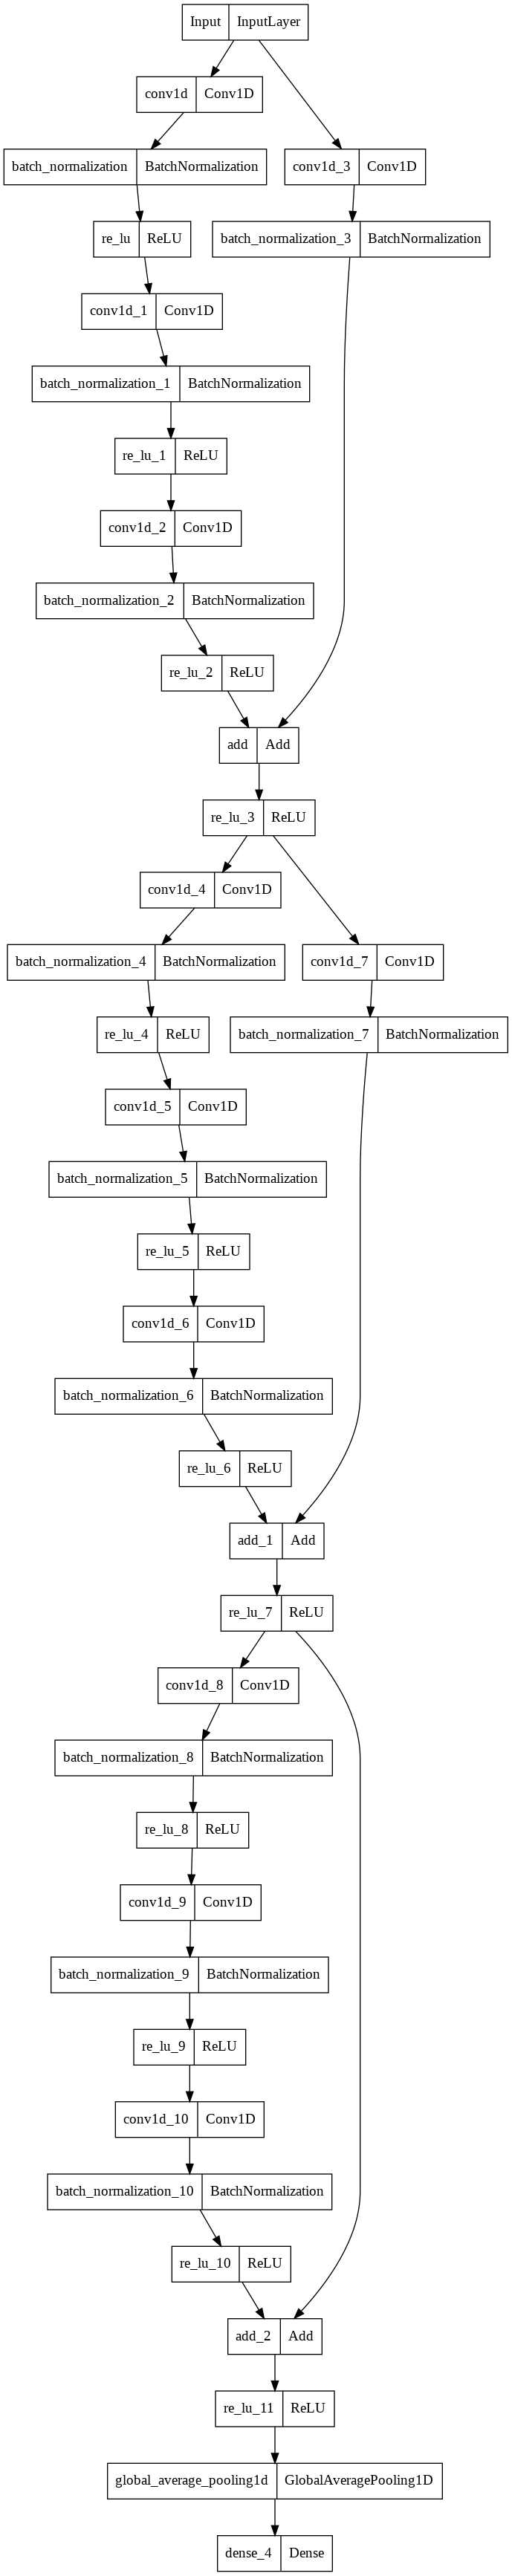

In [ ]:
plot_model(model)

## 1D Conv

Our approach with CNNs is to have a multi-headed model, where each head of the model reads the input time steps using a different sized kernel.

In particular, we used a three-headed model with three different kernel sizes of 3, 5, 8, allowing the model to read and interpret the sequence data at three different resolutions. The interpretations from all three heads are then concatenated within the model and interpreted by a fully-connected layer before a prediction is made.

In [ ]:
def build_1DCNN_classifier_multihead(input_shape, classes):
    inputs = tfkl.Input(shape=input_shape)
    inputs = tfkl.BatchNormalization()(inputs)
    # head 1
    cnn1 = tfkl.Conv1D(128,3,padding='same',activation='relu')(inputs)
    cnn1 = tfkl.MaxPooling1D()(cnn1)
    cnn1 = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn1)
    gap1 = tfkl.GlobalAveragePooling1D()(cnn1)
    dropout1 = tfkl.Dropout(.5 ,seed=seed)(gap1)
    # head 2
    cnn2 = tfkl.Conv1D(128,5,padding='same',activation='relu')(inputs)
    cnn2 = tfkl.MaxPooling1D()(cnn2)
    cnn2 = tfkl.Conv1D(128,5,padding='same',activation='relu')(cnn2)
    gap2 = tfkl.GlobalAveragePooling1D()(cnn2)
    dropout2 = tfkl.Dropout(.5 ,seed=seed)(gap2)
    # head 3
    cnn3 = tfkl.Conv1D(128,8,padding='same',activation='relu')(inputs)
    cnn3 = tfkl.MaxPooling1D()(cnn3)
    cnn3 = tfkl.Conv1D(128,8,padding='same',activation='relu')(cnn3)
    gap3 = tfkl.GlobalAveragePooling1D()(cnn3)
    dropout3 = tfkl.Dropout(.5,seed=seed)(gap3)

    # merge
    merged = tfkl.concatenate([dropout1, dropout2,dropout3])#dropout4,dropout5])
    # interpretation
    dense1 = tfkl.Dense(128, activation='relu')(merged)

    outputs = tfkl.Dense(classes, activation='softmax')(dense1)
    model = tfk.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = build_1DCNN_classifier_multihead(input_shape, classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 36, 128)      2432        ['input_2[0][0]']                
                                                                                                  
 conv1d_13 (Conv1D)             (None, 36, 128)      3968        ['input_2[0][0]']                
                                                                                                  
 conv1d_15 (Conv1D)             (None, 36, 128)      6272        ['input_2[0][0]']                
                                                                                              

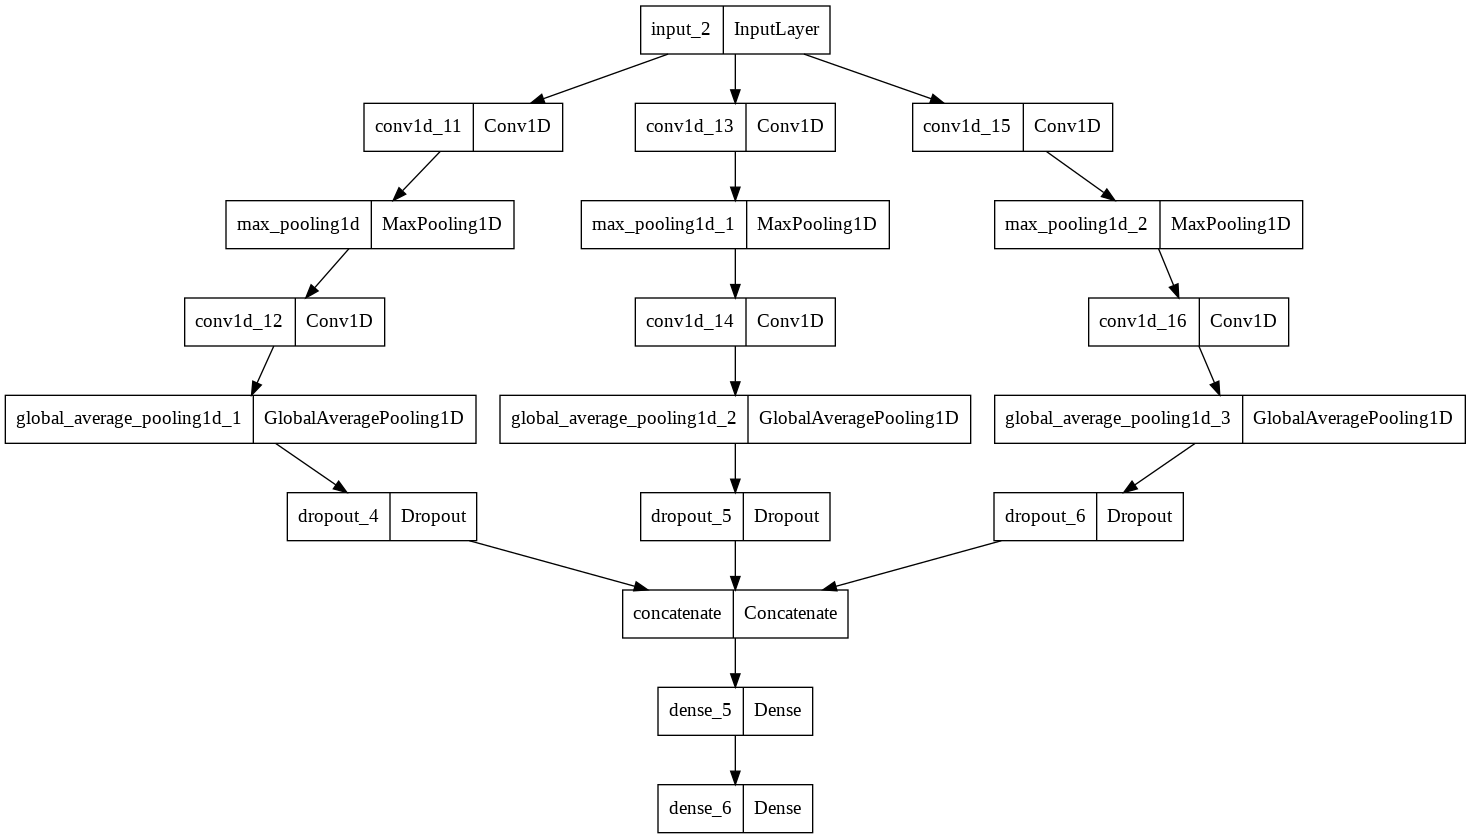

In [ ]:
plot_model(model)

## Transformer

A special mention should be made for a transformer model that we tested.


This is the Transformer architecture from *Attention Is All You Need*, applied to timeseries instead of natural language.

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tfk.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(classes, activation="softmax")(x)
    return tfk.Model(inputs, outputs)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 36, 6)       27654       ['input_3[0][0]',                
 dAttention)                                                      'input_3[0][0]']                
                                                                                                  
 dropout_7 (Dropout)            (None, 36, 6)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 36, 6)       0           ['dropout_7[0][0]',        

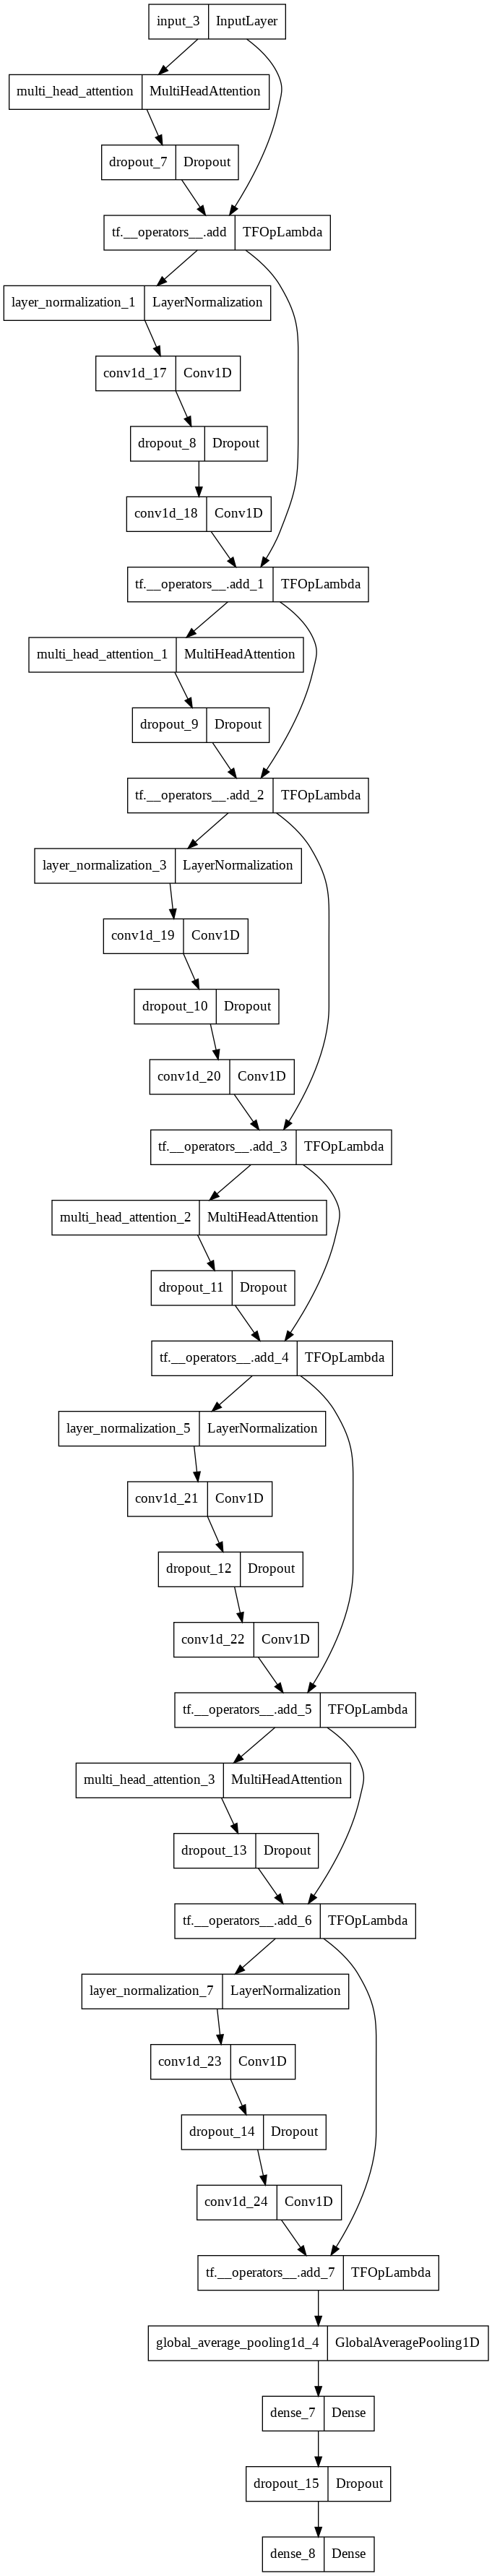

In [ ]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tfk.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)
model.summary()
plot_model(model)

It didn't help us much, but it's an interesting method of applying the attention mechanism to time series classification task.

## Ensemble [ FINAL MODEL ]

The best model we obtained was with an ensemble of 6 multihead 1DConv models using different batch sizes: 
128 - 64 - 32 - 16 - 8 - 4








Let's define all our models.

In [ ]:
model128 = build_1DCNN_classifier_multihead(input_shape, classes)

In [ ]:
model64 = build_1DCNN_classifier_multihead(input_shape, classes)

In [ ]:
model32 = build_1DCNN_classifier_multihead(input_shape, classes)

In [ ]:
model16 = build_1DCNN_classifier_multihead(input_shape, classes)

In [ ]:
model8 = build_1DCNN_classifier_multihead(input_shape, classes)

In [ ]:
model4 = build_1DCNN_classifier_multihead(input_shape, classes)

And train them.

(Uncomment this part if you want to train in this notebook)

In [ ]:
# Train the model
# history = model128.fit(
#     x = X_train_aug,
#     y = y_train_aug,
#     batch_size = 128,
#     epochs = epochs,
#     validation_data=(X_val, y_val),
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
#     ]
# ).history


In [ ]:
# Train the model
# history = model64.fit(
#     x = X_train_aug,
#     y = y_train_aug,
#     batch_size = 64,
#     epochs = epochs,
#     validation_data=(X_val, y_val),
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
#     ]
# ).history

In [ ]:
# Train the model
# history = model32.fit(
#     x = X_train_aug,
#     y = y_train_aug,
#     batch_size = 32,
#     epochs = epochs,
#     validation_data=(X_val, y_val),
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
#     ]
# ).history

In [ ]:
# Train the model
# history = model16.fit(
#     x = X_train_aug,
#     y = y_train_aug,
#     batch_size = 16,
#     epochs = epochs,
#     validation_data=(X_val, y_val),
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
#     ]
# ).history

In [ ]:
# Train the model
# history = model8.fit(
#     x = X_train_aug,
#     y = y_train_aug,
#     batch_size = 8,
#     epochs = epochs,
#     validation_data=(X_val, y_val),
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
#     ]
# ).history

In [ ]:
# Train the model
# history = model4.fit(
#     x = X_train_aug,
#     y = y_train_aug,
#     batch_size = 4,
#     epochs = epochs,
#     validation_data=(X_val, y_val),
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
#     ]
# ).history

We define a Weighted Average Layer for combining our models.

In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, weights, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w = weights

    def call(self, inputs):
        result = 0
        for i in range(len(inputs)):
            result += self.w[i] * inputs[i]
        return result

We ensemble all the models

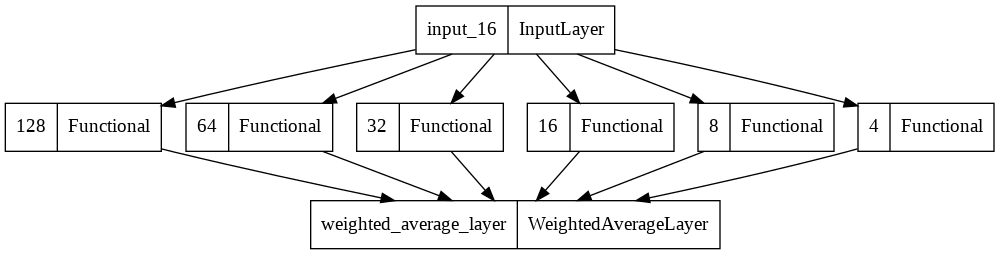

In [ ]:
# rename the models before the ensembling
model128._name="128"
model64._name="64" 
model32._name="32" 
model16._name="16"
model8._name="8"
model4._name="4"

models = [model128,model64,model32,model16,model8,model4]
model_input = tf.keras.Input(shape=input_shape)
model_outputs = [model(model_input) for model in models]
# we use the same weight for all the models
ensemble_output =  WeightedAverageLayer([1,1,1,1,1,1])(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output) 

plot_model(ensemble_model)

We import for simplicity our best model obtained after the previous training.

(comment this part if you trained on the notebook)

In [ ]:
# download the model
if os.path.isdir('Temp')==False:
  os. mkdir("Temp")
dataset_path = get_file(
            'model.zip',
            'https://drive.google.com/uc?export=download&id=14teQS7_GqziyUeBXbwzmcUOtlBJ5kznR&confirm=t',
            cache_dir="Temp")

# extract the zip file in the content directory 
!unzip Temp/datasets/model.zip

20754470/20754470 [==============================] - 0s 0us/step
Archive:  Temp/datasets/model.zip
   creating: BestModel/assets/
  inflating: BestModel/keras_metadata.pb  
  inflating: BestModel/saved_model.pb  
  inflating: BestModel/scaler.pkl    
   creating: BestModel/variables/
  inflating: BestModel/variables/variables.data-00000-of-00001  
  inflating: BestModel/variables/variables.index  


In [ ]:
# load the model
ensemble_model = tf.keras.models.load_model("BestModel")

Let's evaluate our final model.

8/8 [==============================] - 8s 19ms/step
Accuracy: 0.8025
Precision: 0.6992
Recall: 0.7159
F1: 0.6614


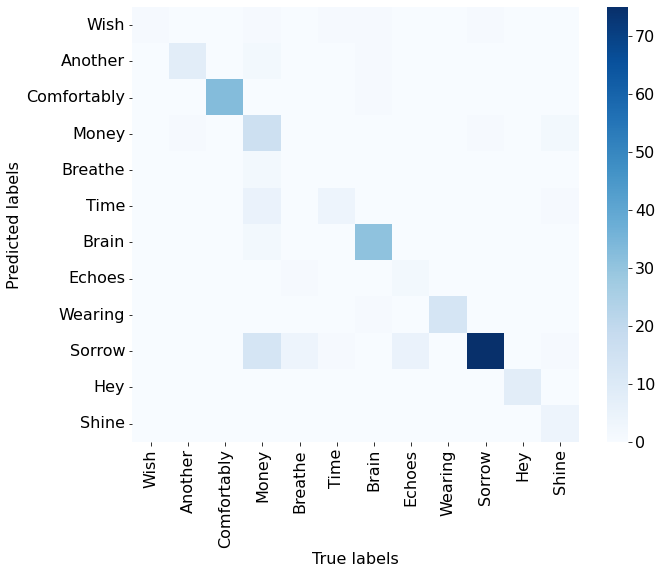

In [ ]:
predictions = ensemble_model.predict(X_test)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

We save the ensemble model and the scaler we used.

In [ ]:
ensemble_model.save('ensemble_model')
pickle.dump(scaler, open('ensemble_model/scaler.pkl','wb'))